# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from enum import Enum

print("GRO620 - Problématique")
print("OpenCV version", cv2.__version__)

%matplotlib inline

GRO620 - Problématique
OpenCV version 4.6.0


In [2]:
images_fn = os.listdir("photos_prob/")
print("%i photo(s) à traiter"%(len(images_fn)))
if (len(images_fn) == 0):
    print("ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin.")
    
images_org = []

for f in images_fn:
    img = cv2.imread(os.path.join("photos_prob/", f))
    images_org.append(img)

9 photo(s) à traiter


Ici on redresse les couleurs dans leur bon canal pour obtenir les couleurs originales des images

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x26fad5c7910>)

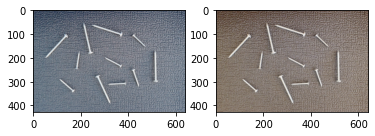

In [3]:
images_colored = []
image_amount: int = len(images_org)

for i in range(image_amount):
    images_colored.append(images_org[i].copy())
    images_colored[i][:, :, 2] = images_org[i][:, :, 0] # (RGB) Canal 0 images_org correspond au bleu donc doit aller dans le canal 2
    images_colored[i][:, :, 0] = images_org[i][:, :, 2] # (RGB) Canal 2 images_org correspond au rouge donc doit aller dans le canal 0

image_nb: int = 0
plt.subplot(1, 2, 1), plt.imshow(images_org[image_nb], cmap="gray")
plt.subplot(1, 2, 2), plt.imshow(images_colored[image_nb])

## Traitement d'image
On filtre d'abord les images pour faire ressortir les vis de l’arrière-plan. Le filtrage de l'image s'effectue en plusieurs étapes.

### Première étape
Appliquer un GaussianBlur pour égaliser la couleur du fond d'une taille de 5x5. Cette taille évite de perdre trop de détail dans les vis.

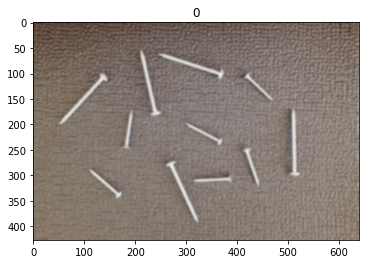

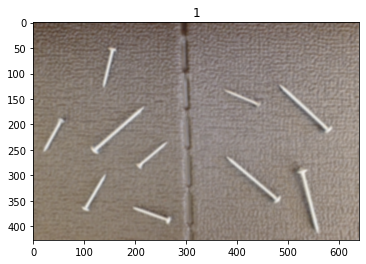

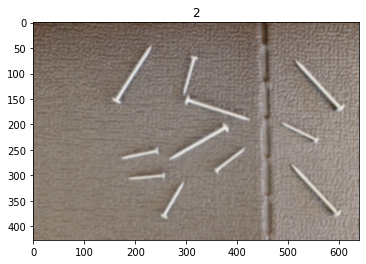

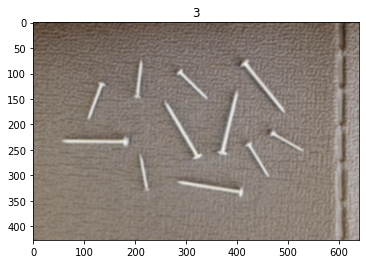

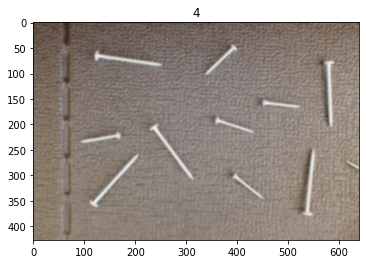

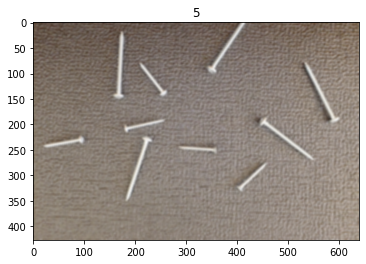

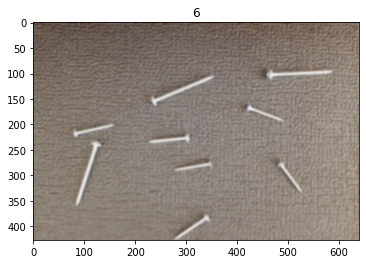

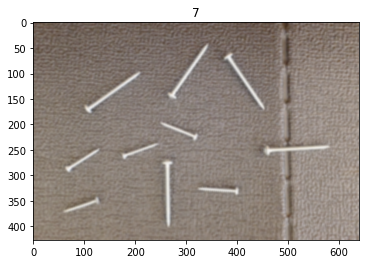

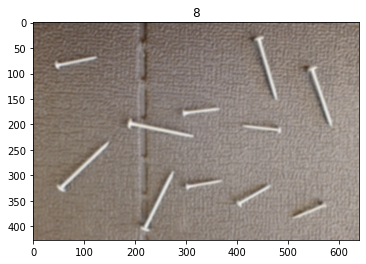

In [4]:
images_blured = []
for index in range(image_amount):
    images_blured.append(images_colored[index].copy())
    
    images_blured[index] = cv2.GaussianBlur(images_blured[index], (5,5), cv2.BORDER_DEFAULT)
    
    plt.figure()
    plt.imshow(images_blured[index], cmap="gray")
    plt.title(index)

### Deuxième étape
On applique un filtre non linéaire de type bilatérale pour lisser le fond et retirer toute la texture du cuire. Le filtre est appliqué 3 fois pour obtenir le lissage désiré.

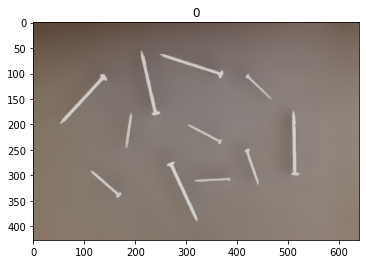

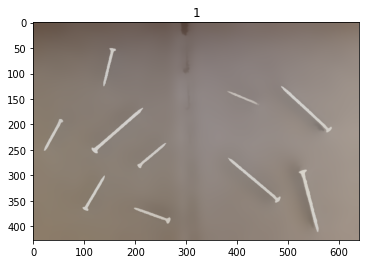

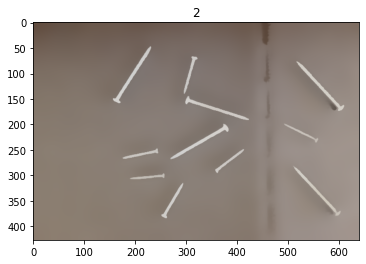

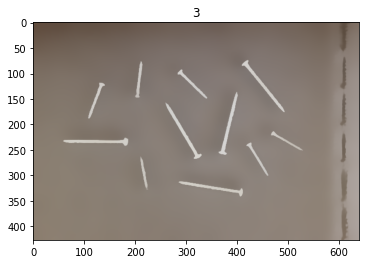

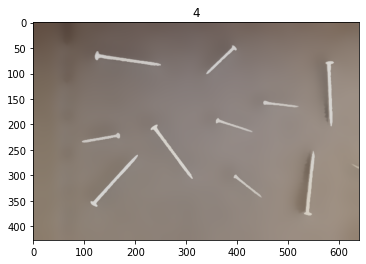

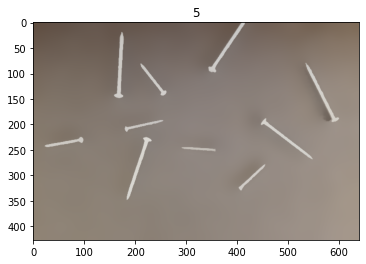

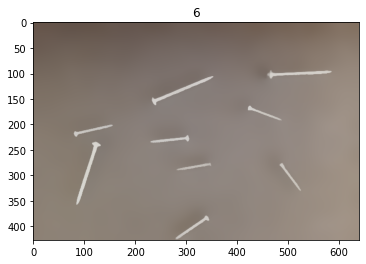

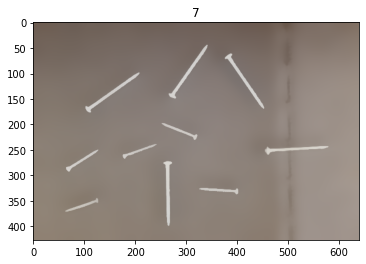

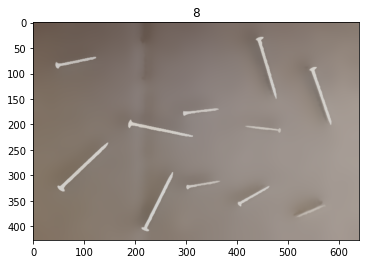

In [5]:
images_filtered = []
for index in range(image_amount):
    images_filtered.append(images_blured[index].copy())
    
    for iteration in range(3):
        images_filtered[index] = cv2.bilateralFilter(images_filtered[index], 30, 55, 50)

    plt.figure()
    plt.imshow(images_filtered[index], cmap="gray")
    plt.title(index)

### Troisième étape
Il reste encore les reliures dans les images qui peuvent être retirées par un seuil de couleur sur l'image convertie en teinte de gris. Une fois l'image convertie en gris, il est possible d'en extraire son histogramme pour voir la répartition de couleur et ainsi déterminer le seuil qui permet d'isoler les vis.

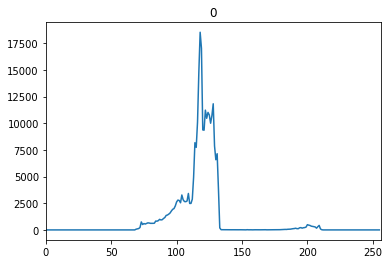

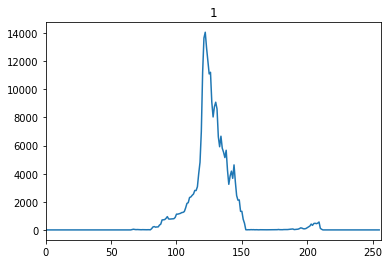

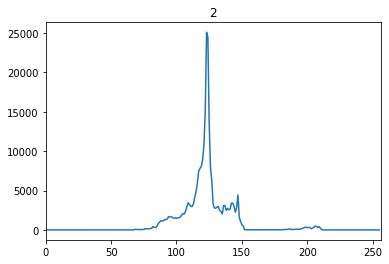

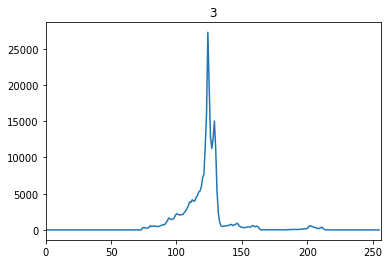

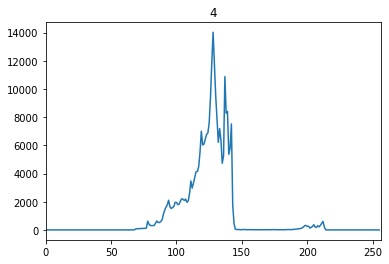

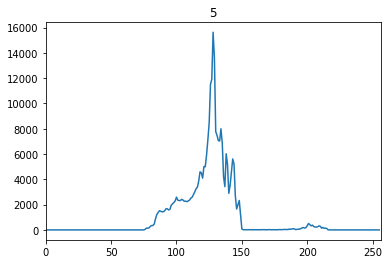

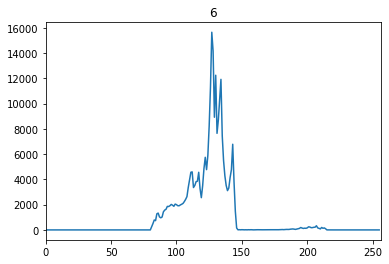

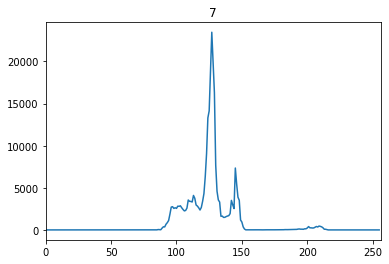

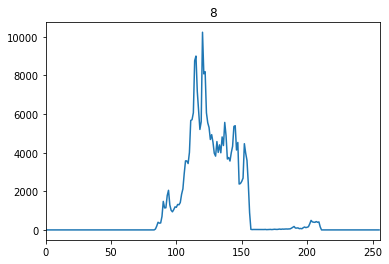

In [6]:
images_gray = []
for index in range(image_amount):
    images_gray.append(images_filtered[index].copy())
    
    images_gray[index] = cv2.cvtColor(images_gray[index], cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([images_gray[index]], [0], None, [256], [0,256])

    plt.figure()
    plt.plot(hist)  # Permet de trouver le threshold à 170 en gris
    plt.xlim([0,256])
    plt.title(index)

### Quatrième étape
Appliquer un seuil à 170 qui est le seuil identifié dans les histogramme de l'étape précédente pour extraire uniquement les vis.

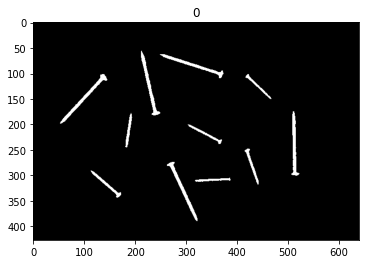

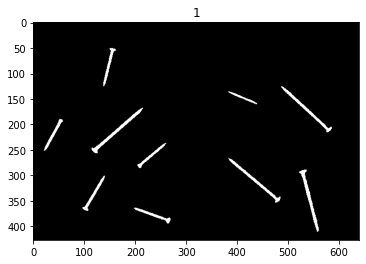

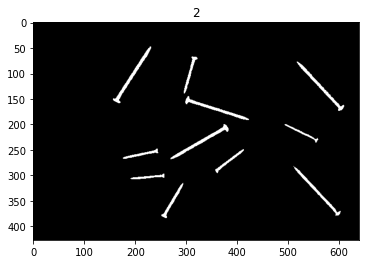

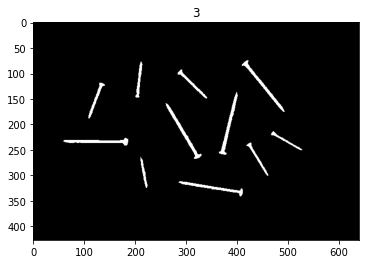

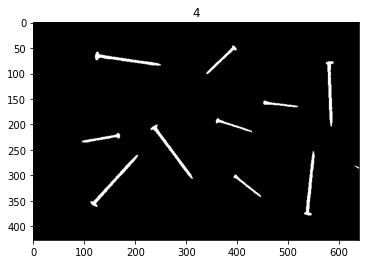

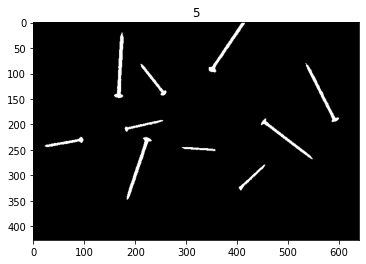

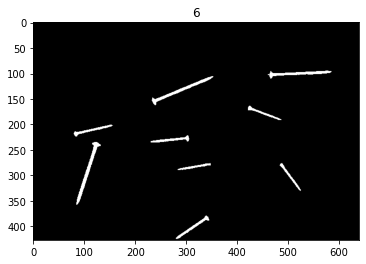

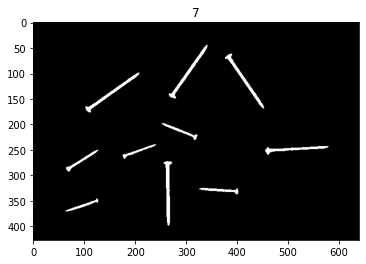

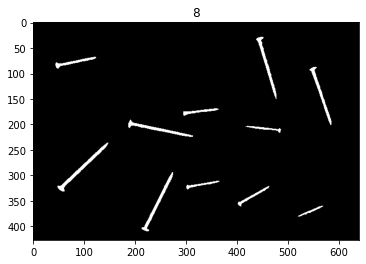

In [7]:
images_thresholded = []
for index in range(image_amount):
    images_thresholded.append(images_gray[index].copy())

    (thresh, images_thresholded[index]) = cv2.threshold(images_thresholded[index], 170, 255, cv2.THRESH_BINARY)
    
    plt.figure()
    plt.imshow(images_thresholded[index], cmap="gray")
    plt.title(index)

## Identification des vis
Une fois l'image traitée et les vis isolées du fond, il est possible d'identifier le centre et l'orientation à partir du contour de chacune des vis.



In [8]:
class Screw_type(Enum):
    longue = 1
    courte = 2

class Line:
    def __init__(self, point_1, point_2):
        self.point_1: tuple = point_1
        self.point_2: tuple = point_2

    def get_angle(self):
        return np.arctan2(self.point_2[1] - self.point_1[1], self.point_2[0] - self.point_1[0])

class Screw():
    def __init__(self, center, length, line: Line):
        self.p_tilde = self._define_projection_matrix()
        self.angle: float = line.get_angle()
        self.type: Screw_type = self._define_screw_type(length)
        (self.x, self.y, self.z) = self._define_screw_coordinates(center)
        

    def _define_projection_matrix(self):
        sensor_height_px = 427
        sensor_width_px = 640
        sensor_width_mm = 23.4
        focal_dist_mm = 23
        focal_dist = focal_dist_mm*sensor_width_px/sensor_width_mm

        Tc = np.array([[1,   0,  0,   0.5],
                      [0,   -1, 0,   0.2],
                      [0,   0,  -1,  0.282],
                      [0,   0,  0,   1]])

        k_tilde = np.array([[focal_dist,   0,          sensor_width_px/2,   0],
                            [0,            focal_dist, sensor_height_px/2,  0],
                            [0,            0,          1,                   0],
                            [0,            0,          0,                   1]])
        
        return np.linalg.inv(k_tilde) @ Tc

    def _define_screw_type(self, length) -> Screw_type:
        if (length > 100):
            return Screw_type.longue
        else:
            return Screw_type.courte

    def _define_screw_coordinates(self, center_px) -> tuple:
        z = 0.282 

        coordinate_camera_frame = np.array([[center_px[0]], [center_px[1]], [1], [1/z]]) * z
        coordinate_conveyor_frame = self.p_tilde @ coordinate_camera_frame
        return tuple([float(coordinate_conveyor_frame[0]), float(coordinate_conveyor_frame[1]), float(coordinate_conveyor_frame[2])])

    


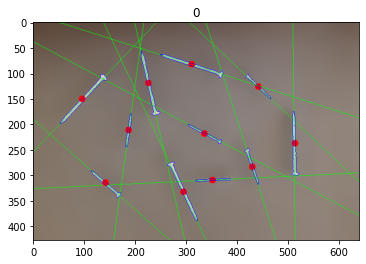

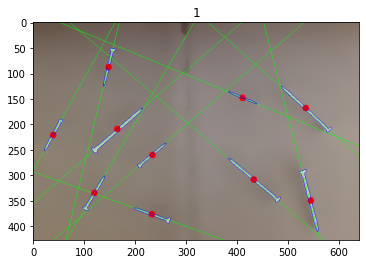

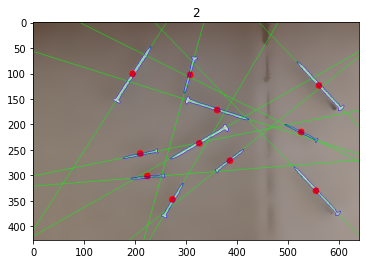

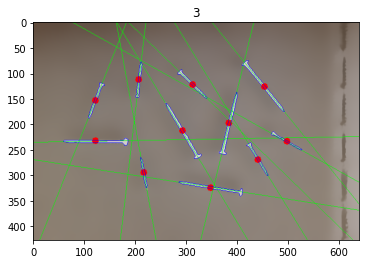

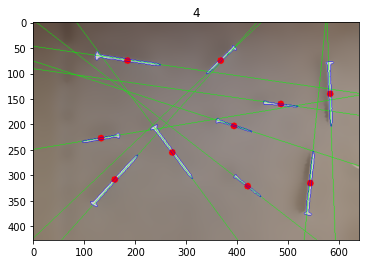

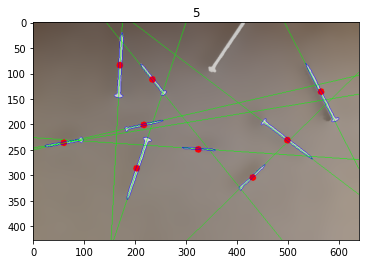

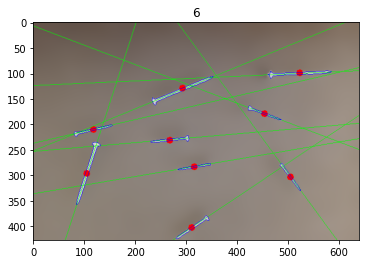

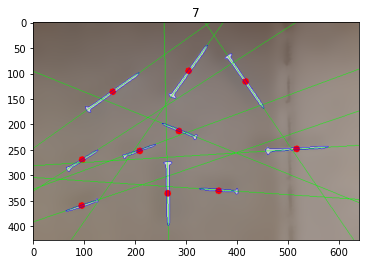

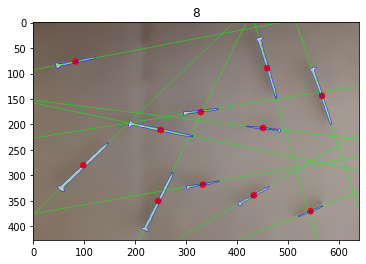

In [9]:
screws = []
images_contour = []

for index in range(image_amount):
    screws.append([])
    images_contour.append(images_filtered[index].copy())

    contours, hierarchy = cv2.findContours(images_thresholded[index], 1, 2)

    detected_screw = []

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        if not (box[0][0] < 2 or box[0][0] > 638 or box[0][1] < 2 or box[0][1] > 425 or
                box[1][0] < 2 or box[1][0] > 638 or box[1][1] < 2 or box[1][1] > 425 or
                box[2][0] < 2 or box[2][0] > 638 or box[2][1] < 2 or box[2][1] > 425 or
                box[3][0] < 2 or box[3][0] > 638 or box[3][1] < 2 or box[3][1] > 425):
            detected_screw.append(contour)

    for contour in detected_screw:
        # Orientation (ligne)
        rows,cols = images_contour[index].shape[:2]
        [vx,vy,x,y] = cv2.fitLine(contour, cv2.DIST_L2,0,0.01,0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        line = Line((cols-1,righty),(0,lefty))
        cv2.line(images_contour[index], line.point_1, line.point_2,(0,255,0),1)

        # Centre et longueur
        (x,y),radius = cv2.minEnclosingCircle(contour)
        center = (int(x),int(y))
        radius_printed: int = 3
        cv2.circle(images_contour[index],center,radius_printed,(255,0,0),5)

        # Contour de chaque vis
        cv2.drawContours(images_contour[index], detected_screw, -1, (0, 0, 255), 1)

        # Ajoute la vis à la liste pour l'image en cours
        screws[index].append(Screw(center, radius*2, line))

    plt.figure()
    plt.imshow(images_contour[index], cmap="gray")
    plt.title(index)

In [12]:
for index in range(image_amount):
    print("Image " + str(index+1))
    print("Id      Type         X(m)       Y(m)         Z(m)     Angle(rad)")
    screw_id = 0
    for screw in screws[index]:
        print("{:d}       {:s}       {:.2f}       {:.2f}       {:.2f}      {:.2f}".format(screw_id, screw.type.name, screw.x, screw.y, screw.z, screw.angle))
        screw_id += 1

Image 1
Id      Type         X(m)       Y(m)         Z(m)     Angle(rad)
0       courte       0.16       -0.14       0.00      3.09
1       courte       0.06       -0.14       0.00      -2.42
2       longue       0.13       -0.15       0.00      -2.01
3       courte       0.19       -0.13       0.00      -1.88
4       courte       0.15       -0.10       0.00      -2.65
5       courte       0.08       -0.09       0.00      1.71
6       longue       0.23       -0.11       0.00      -1.58
7       courte       0.20       -0.06       0.00      -2.39
8       longue       0.04       -0.07       0.00      2.33
9       longue       0.14       -0.04       0.00      -2.83
10       longue       0.10       -0.05       0.00      -1.80
Image 2
Id      Type         X(m)       Y(m)         Z(m)     Angle(rad)
0       courte       0.11       -0.17       0.00      -2.80
1       courte       0.05       -0.15       0.00      2.10
2       longue       0.25       -0.16       0.00      -1.82
3       longue   